# CANDY Data Parser

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import matplotlib.pyplot as plt

In [2]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [40]:
fto = './data/DATALOG.TXT' #  File to Open
l=[]
l.extend(range(0,1030))
df = pd.read_csv(fto, sep=',', header=None, names=l, comment='*')

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

# Convert strings to numbers
#df = df.apply(pd.to_numeric, errors='ignore')

#df.iloc[:,0:13]

#df

## Concatenate RMC and GGA lines to one table

In [41]:
df = df.reset_index(drop=True)
df1 = df.loc[df[0]=='$GPRMC']
df1 = df1.iloc[:,0:12]
df2 = df.iloc[df.loc[df[0]=='$GPRMC'].index+1]
df2 = df2.iloc[:,0:15]
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)
df5 = pd.concat([df1,df2], axis=1,  ignore_index=True)
# Convert NMEA time to pandas time
df5[9] = df5[9].astype(str)
df5[1] = df5[1].astype(str)
df5[1] = pd.to_datetime(df5[9]+df5[1], format='%d%m%y%H%M%S.%f',errors='coerce')#.dt.time
#df5=df5.rename(columns = {2:'time'})#
#df5 = df5.iloc[:,0:20]

df5.drop(df5[df5[24]!='M'].index, inplace=True)

df5[21] = pd.to_numeric(df5[21],errors='coerce')

df6 = pd.DataFrame()
df6['time']=df5[1]
df6['altitude'] = df5[21]
df6['Lat'] = df5[3]
df6['Lats'] = df5[4]
df6['Lon'] = df5[5]
df6['Lons'] = df5[6]
df6['time'] = pd.to_datetime(df6.time)
df6.set_index('time', inplace=True)
df6.dropna(axis=0,inplace=True)
df6 = df6[pd.notnull(df6.index)]
df6.to_csv('ble.txt')
#df6.iloc[50:100]

## Calculate Flux

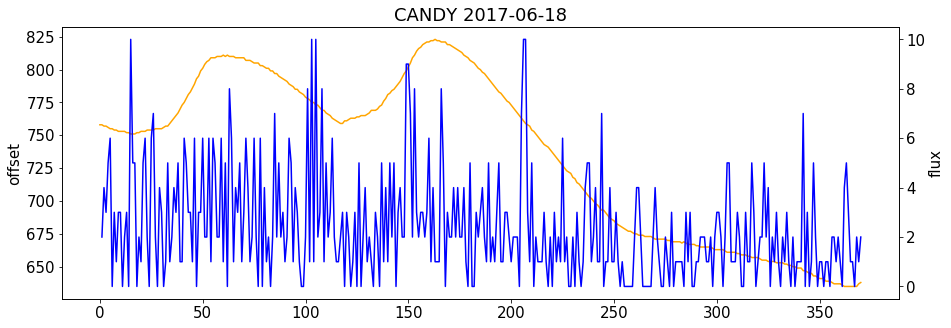

In [5]:
plt.figure(figsize=(15,5))
matplotlib.rcParams.update({'font.size': 15})

rc = df.loc[df[0]=='$CANDY']
rc.reset_index(drop=True, inplace=True)

rc = rc.apply(pd.to_numeric, errors='coerce')

#rc.to_csv('ble.txt')

#rc['sum'] = rc[range(24,544)].sum(axis=1)
#rc['flux'] = rc[range(rc[1026]+10,1025)].sum(axis=1)
rc['flux'] = rc[1026]
#rc['sum'] = rc[range(21,21)].sum(axis=1)
#rc['sum']

for line in range(1,len(rc)):
    rc.ix[line,'sum'] = 0 
    for col in range(int(rc.ix[line,1026])+10,1026):
        rc.ix[line,'sum'] += rc.ix[line,col]  
            
rc['flux'].plot(c='orange')
plt.ylabel('offset')

plt.twinx()

plt.plot(rc['sum'],c='blue')
plt.ylabel('flux')

#plt.ylim([0,20])
plt.title('CANDY 2017-06-18')
plt.xlabel('measurement No.')


## Plot Altitude

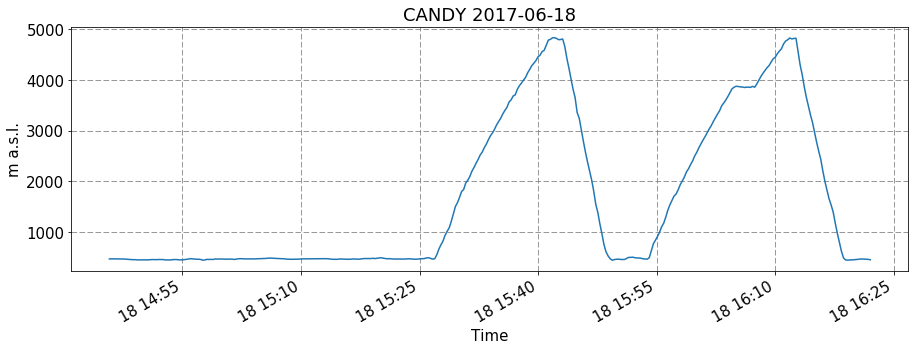

In [6]:
plt.figure(figsize=(15,5))
matplotlib.rcParams.update({'font.size': 15})

#df6.set_index('time').altitude.plot()
plt.plot(df6.index, df6.altitude)

plt.xticks(rotation='vertical')
plt.gcf().autofmt_xdate()
#df5[:17000].plot(x=2,y='avgsnr',figsize=(12,5),xticks=['09:30:00','10:00:00','10:30:00','11:00:00','11:30:00','12:00:00','12:30:00','13:00:00','13:30:00','14:00:00'])
plt.grid(b=True, which='major', color='grey', linestyle='--')
plt.grid(b=True, which='minor', color='grey', linestyle='-')

plt.title('CANDY 2017-06-18')
plt.xlabel('Time')
plt.ylabel('m a.s.l.')

## Convert Grades/Minutes to Grades

In [42]:
df6['Lat'] = df6['Lat'].astype(float)
df6['Lon'] = df6['Lon'].astype(float)

df6['Lats'] = df6['Lats'].str.replace('N','1')
df6['Lats'] = df6['Lats'].str.replace('S','-1')
df6['Lons'] = df6['Lons'].str.replace('E','1')
df6['Lons'] = df6['Lons'].str.replace('W','-1')

df6['LatDD'] = (df6.Lat/100).fillna(0).astype(int)
df6['LatDD'] = df6.LatDD + (df6.Lat - 100.0*df6.LatDD)/60.0
df6['LatDD'] = df6.LatDD * df6['Lats'].astype(float)  


df6['LonDD'] = (df6.Lon/100).fillna(0).astype(int)
df6['LonDD'] = df6.LonDD + (df6.Lon - 100.0*df6.LonDD)/60.0
df6['LonDD'] = df6.LonDD * df6['Lons'].astype(float)  

## Plot Map

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=414997.959665,5502255.91351,435498.450526,5525590.58305&bboxSR=31284&imageSR=31284&size=500,569&dpi=96&format=png32&f=image


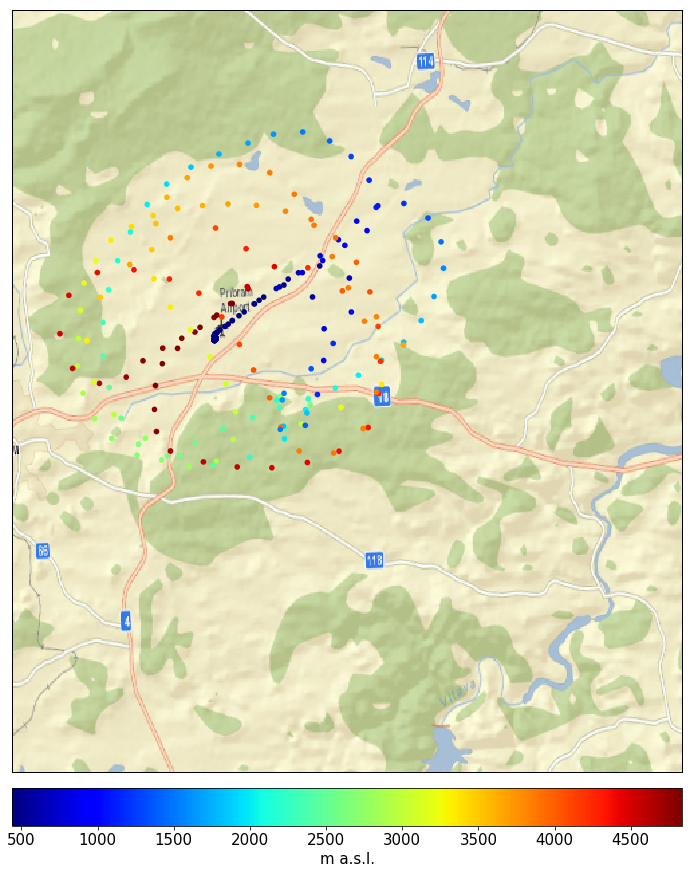

In [58]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

plt.figure(figsize=(15,15))

# draw map with markers for float locations
#m = Basemap(projection='kav7',lon_0=0)
# create Basemap instance.
#m = Basemap(llcrnrlon=18.1,llcrnrlat=52.9,urcrnrlon=18.7,urcrnrlat=53.1,projection='mill')

#m = Basemap(llcrnrlon=18.1,llcrnrlat=52.9,urcrnrlon=18.7,urcrnrlat=53.1, epsg = 31284,resolution='i',projection='merc',lon_0=14.8,lat_0=47.2)
m = Basemap(llcrnrlon=14.0,llcrnrlat=49.6,urcrnrlon=14.3,urcrnrlat=49.8, epsg = 31284,resolution='i',projection='merc')
m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 500, verbose= True)
#49.7182503N, 14.0948878E

#xx = df6.loc['2017-06-18 15:50:00':'2017-06-18 16:20:00']
xx = df6
xx = xx.dropna(how='any')


x, y = m(xx.LonDD.tolist(),xx.LatDD.tolist())
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.

m.drawparallels(np.arange(52.,54.,.1),labels=[1,1,0,0])
m.drawmeridians(np.arange(18.,19.,.1),labels=[0,0,1,0])

#m.scatter(df6.LonDD.tolist(),df6.LatDD.tolist(),3,marker='o',color='r')
im1 = m.scatter(x,y,c=df6.altitude.tolist(),s=7,marker='o',  linewidth='3', cmap='jet')
#im1 = m.scatter(x,y,s=7,marker='o',  linewidth='3', cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')
plt.show()

## Plot Flux

In [9]:

date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
altitude = np.nan
LatDD = np.nan
LonDD = np.nan
for i,r in df.iterrows():
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
    '''
        Lat = float(r[3])
        Lon = float(r[5])

        if (r[4] == 'N'):
            Lats = 1
        else:
            Lats = -1

        if (r[6] == 'E'):
            Lons = 1
        else:
            Lons = -1

        LatDD = int(Lat/100)
        LatDD = LatDD + (Lat - 100.0*LatDD)/60.0
        LatDD = LatDD * Lats  

        LonDD = int(Lon/100)
        LonDD = LonDD + (Lon - 100.0*LonDD)/60.0
        LonDD = LonDD * Lons  
    '''       
    if (r[0] == '$GPGGA'):
        altitude = r[9]
    #r[20] = date
    #df.set_value(i,20,date)
    #df.set_value(i,21,altitude)
    df.set_value(i,'date',date)
    df.set_value(i,'alt',altitude)
    #df.set_value(i,22,LatDD)
    #df.set_value(i,23,LonDD)

#df.to_csv('complete.csv')

In [10]:
#dfo = df[[25,26,27]].reset_index().groupby(20).sum()
#df.reset_index(inplace=True)
dfo = df
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)

#dfo.set_index(20,inplace=True)

#dfo = dfo[range(24,544)].groupby(20).sum()
#dfo[19] = dfo[range(24,544)].sum(axis=1)
dfo['flux'] = dfo[range(24,544)].sum(axis=1)

#dfo

#df.iloc[20:40,0:30]
#dfo['sum'] = dfo[range(27,544)].sum(axis=1)

dfo.to_csv('radiation.csv')

                     Unnamed: 0       0    1  2  3  4  5  6  7  8   ...    \
date                                                                ...     
NaT                           0  $CANDY    0  0  0  0  0  0  0  0   ...     
NaT                           5  $CANDY    1  0  0  0  0  0  0  0   ...     
2017-06-18 14:45:14           8  $CANDY    2  0  0  0  0  0  0  0   ...     
2017-06-18 14:45:30          12  $CANDY    3  0  0  0  0  0  0  0   ...     
2017-06-18 14:45:46          16  $CANDY    4  0  0  0  0  0  0  0   ...     
2017-06-18 14:46:02          20  $CANDY    5  0  0  0  0  0  0  0   ...     
2017-06-18 14:46:18          24  $CANDY    6  0  0  0  0  0  0  0   ...     
2017-06-18 14:46:34          28  $CANDY    7  0  0  0  0  0  0  0   ...     
2017-06-18 14:46:50          32  $CANDY    8  0  0  0  0  0  0  0   ...     
2017-06-18 14:47:06          36  $CANDY    9  0  0  0  0  0  0  0   ...     
2017-06-18 14:47:22          40  $CANDY   10  0  0  0  0  0  0  0   ...     

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1,center=False).mean()


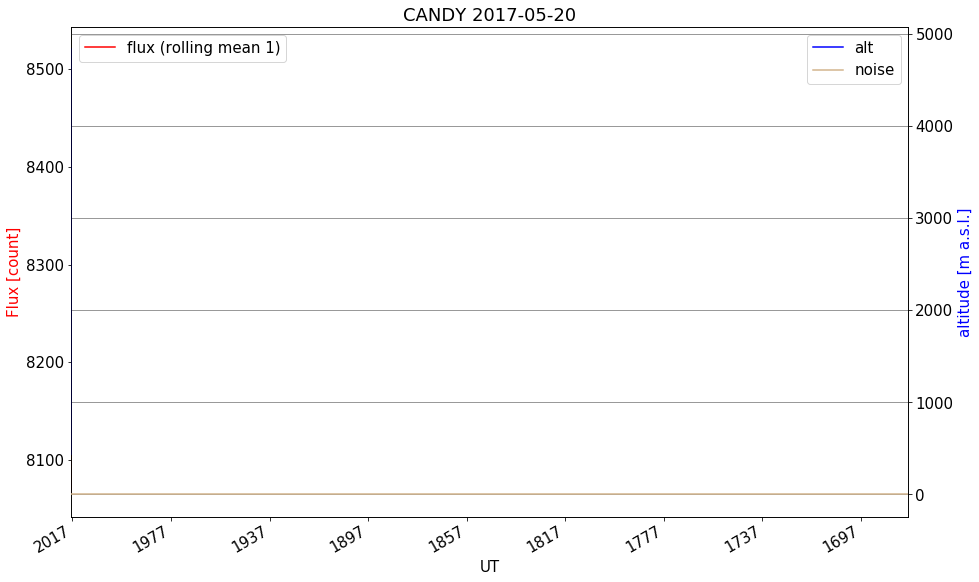

In [14]:
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 15})

dfo = pd.read_table('radiation.csv', sep=',', header=0)
#dfo = dfo.dropna(how='any')
dfo['date'] = pd.to_datetime(dfo['date'])
dfo = dfo.set_index(['date'])

for line in range(1,len(dfo)):
    dfo.ix[line,'sum'] = 0 
    for col in range(int(dfo.ix[line,1026])+10,1026):
        dfo.ix[line,'sum'] += dfo.ix[line,col]  

print dfo

#dfo['flux'] = dfo[1026]
#xx = dfo.loc['2017-05-20 11:00:00':'2017-05-20 14:30:00']
xx = dfo
#pandas.rolling_mean(arg, window, min_periods=None, freq=None, center=False, how=None, **kwargs)
window = 1
xx['flux'] = pd.rolling_mean(xx['sum'],window)

xx['flux'].plot(c='r', label='flux (rolling mean '+str(window)+')')
plt.xlabel('UT')
plt.ylabel('Flux [count]', color='red')
#, xticks=['2017-03-27 00:00','2017-03-27 12:00','2017-03-28 00:00','2017-03-28 12:00','2017-03-29 00:00'],figsize=(20,5))
plt.legend(loc=2)

ax = plt.twinx()
xx['alt'].plot(c='b',label='alt')
plt.plot(xx['18']*100,c='tan',label='noise',zorder=10)
#plt.plot(xx[19]*5000-xx['18']*100,c='green',label='corr')
plt.ylabel('altitude [m a.s.l.]', color='blue')
#plt.ylim([0,500])
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()
plt.title('CANDY 2017-05-20')


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


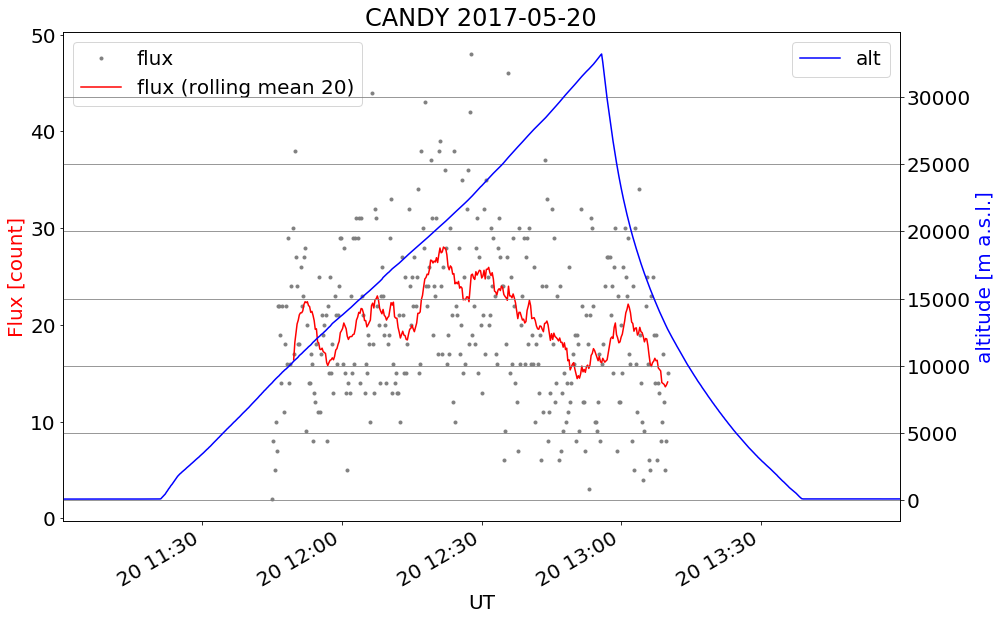

In [156]:
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 20})

xx = dfo.loc['2017-05-20 11:00:00':'2017-05-20 14:00:00']

xx.loc[:'2017-05-20 11:45:00','sum'] = np.nan
#xx.loc['2017-05-20 13:30:00':,'sum'] = np.nan

window = 20
xx['flux'] = pd.rolling_mean(xx['sum'],window)

xx['sum'].plot(c='grey', label='flux',linestyle='None', marker='.')
xx['flux'].plot(c='r', label='flux (rolling mean '+str(window)+')')
plt.xlabel('UT')
plt.ylabel('Flux [count]', color='red')
#, xticks=['2017-03-27 00:00','2017-03-27 12:00','2017-03-28 00:00','2017-03-28 12:00','2017-03-29 00:00'],figsize=(20,5))
plt.legend(loc=2)
#plt.grid(b=True, which='major', color='khaki', linestyle='-')

ax = plt.twinx()

xx['alt'].plot(c='b',label='alt')
#plt.plot(xx['18']*100,c='tan',label='noise',zorder=10)
#plt.plot(xx[19]*5000-xx['18']*100,c='green',label='corr')
plt.ylabel('altitude [m a.s.l.]', color='blue')
#plt.ylim([0,500])
plt.grid(b=True, which='major', color='grey', linestyle='-')
#plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()
plt.title('CANDY 2017-05-20')


## Plot Effective Doserate in Silicon

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


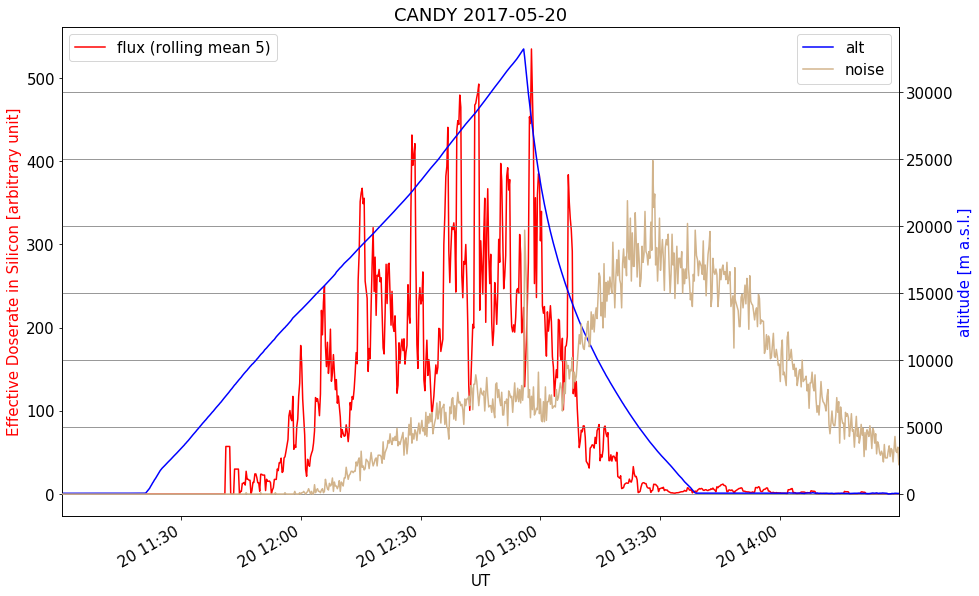

In [28]:
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 15})

dfo = pd.read_table('radiation.csv', sep=',', header=0)
dfo = dfo.dropna(how='any')
dfo['20'] = pd.to_datetime(dfo['20'])
dfo = dfo.set_index(['20'])
NOISE_LEVEL=25
dfo[range(NOISE_LEVEL,500)] = dfo[range(NOISE_LEVEL,500)].mul(range(1,500+1-NOISE_LEVEL),axis=1)
dfo[19] = dfo[range(NOISE_LEVEL,500)].sum(axis=1)
xx = dfo.loc['2017-05-20 11:00:00':'2017-05-20 14:30:00']
#xx = dfo
#pandas.rolling_mean(arg, window, min_periods=None, freq=None, center=False, how=None, **kwargs)
WINDOW = 5
xx[19] = pd.rolling_mean(xx[19],WINDOW)

xx[19].plot(c='r', label='flux (rolling mean '+str(window)+')')
plt.xlabel('UT')
plt.ylabel('Effective Doserate in Silicon [arbitrary unit]', color='red')
#, xticks=['2017-03-27 00:00','2017-03-27 12:00','2017-03-28 00:00','2017-03-28 12:00','2017-03-29 00:00'],figsize=(20,5))
plt.legend(loc=2)

ax = plt.twinx()
xx['21'].plot(c='b',label='alt')
plt.plot(xx['18']*100,c='tan',label='noise',zorder=10)
#plt.plot(xx[19]*5000-xx['18']*100,c='green',label='corr')
plt.ylabel('altitude [m a.s.l.]', color='blue')
#plt.ylim([0,500])
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()
plt.title('CANDY 2017-05-20')


In [55]:
xx.loc[xx['altitude']<500.1]

,altitude,Lat,Lats,Lon,Lons,LatDD,LonDD
time,,,,,,,
2017-06-18 15:50:09,462.9,4943.06785,1,1405.69121,1,49.717798,14.094853
2017-06-18 15:50:25,456.9,4943.01981,1,1405.67844,1,49.716997,14.094641
2017-06-18 15:50:41,455.4,4942.99539,1,1405.70968,1,49.716590,14.095161
2017-06-18 15:50:56,456.7,4942.99039,1,1405.70940,1,49.716507,14.095157
2017-06-18 15:51:12,477.5,4942.98735,1,1405.72056,1,49.716456,14.095343
2017-06-18 15:51:27,497.4,4942.99463,1,1405.71679,1,49.716577,14.095280
2017-06-18 15:51:43,497.7,4942.99491,1,1405.71684,1,49.716582,14.095281
2017-06-18 15:52:14,491.1,4942.99469,1,1405.71630,1,49.716578,14.095272
2017-06-18 15:52:30,485.3,4942.99158,1,1405.71663,1,49.716526,14.095277


In [56]:
df6.altitude.tolist()

[467.1,
 468.9,
 468.3,
 469.2,
 469.2,
 467.9,
 467.8,
 465.1,
 462.0,
 458.3,
 454.8,
 452.2,
 453.0,
 448.8,
 447.8,
 449.2,
 448.9,
 449.7,
 447.2,
 451.0,
 452.7,
 454.8,
 452.5,
 454.4,
 455.3,
 454.7,
 454.4,
 445.6,
 448.7,
 445.2,
 451.0,
 454.6,
 455.2,
 451.6,
 447.8,
 448.1,
 452.7,
 458.7,
 464.4,
 472.7,
 467.0,
 465.3,
 459.4,
 461.3,
 455.6,
 442.4,
 447.4,
 458.7,
 456.2,
 458.9,
 456.3,
 466.3,
 463.3,
 466.0,
 466.3,
 464.5,
 461.8,
 463.5,
 463.8,
 463.5,
 456.8,
 463.9,
 469.9,
 472.0,
 470.8,
 467.4,
 468.3,
 467.8,
 467.9,
 467.8,
 467.3,
 470.8,
 471.5,
 472.6,
 476.2,
 476.0,
 481.3,
 483.9,
 480.7,
 479.0,
 477.6,
 475.9,
 472.9,
 470.9,
 468.8,
 461.8,
 462.2,
 459.5,
 461.1,
 462.1,
 461.8,
 464.5,
 466.8,
 468.7,
 467.9,
 468.9,
 468.9,
 468.8,
 468.3,
 470.0,
 470.8,
 471.6,
 472.5,
 472.1,
 471.5,
 467.2,
 461.7,
 459.1,
 459.8,
 459.7,
 465.8,
 465.7,
 462.7,
 460.4,
 461.0,
 459.3,
 465.9,
 465.6,
 462.7,
 461.9,
 464.2,
 470.8,
 474.9,
 475.3,
 477.0,
